# $R_S$ vs. $R_N$ and $R_{NNS}$ vs. $R_{NS}$  barplots for each genome

In [1]:
%run "Header.ipynb"

In [2]:
import json
import skbio
from statistics import median
from math import log
from matplotlib import pyplot
from parse_sco import parse_sco

In [3]:
with open("matrix-jsons/seq2gene2codon2alignedcodons.json", "r") as jf:
    seq2gene2codon2alignedcodons = json.load(jf)

## _minfreq_ values

Currently the same as in the codon mutation notebook. I guess these should be a shared variable, ideally? But that might be too much work for its own good.

In [4]:
percentages = [2, 1, 0.5, 0.25, 0.1, 0.05, 0]

## Compute counts for each sequence for each percentage

Helps us separate computation (which takes a few minutes on the cluster as of writing) from plotting.

Plotting this data is actually relatively fast, since this computation only results in a handful of data points: the exact number of data points is (num percentages) &times; (num sequences) &times; 2. So, for 7 percentages (`2, 1, 0.5, 0.25, 0.1, 0.05, 0`) and 3 sequences (`CAMP`, `BACTERIA`, `BACTEROIDALES`), this results in 42 data points.

In [5]:
p2seq2synvals = {p: {} for p in percentages}
p2seq2nonsensevals = {p: {} for p in percentages}

# Code partially yanked from the mutation matrix notebook
for seq in SEQS:
    print(f"On seq {seq}.")

    p2singlent_synonymous_codon_mutation_ct = {p: 0 for p in percentages}
    p2singlent_nonsynonymous_codon_mutation_ct = {p: 0 for p in percentages}
    
    p2singlent_nonnonsense_codon_mutation_ct = {p: 0 for p in percentages}
    p2singlent_nonsense_codon_mutation_ct = {p: 0 for p in percentages}

    fasta = skbio.DNA.read("../seqs/{}.fasta".format(seq))
    df = parse_sco("../seqs/genes/{}.sco".format(seq))

    for gene_data in df.itertuples():
        print(f"On gene {gene_data.Index} / {len(df.index)} in seq {seq}.")

        for cpleft in range(gene_data.LeftEnd, gene_data.RightEnd + 1, 3):

            # Make note of the codon sequence and amino acid encoded by this codon in the "reference" genome.
            # (Keep in mind that the gene data in the .sco file uses 1-indexed coords, so we need to convert
            # accordingly.)
            codon_dna = fasta[cpleft - 1: cpleft + 2]
            if gene_data.Strand == "-":
                codon_dna = codon_dna.reverse_complement()

            codon_seq = str(codon_dna)

            aligned_codons = seq2gene2codon2alignedcodons[seq][str(gene_data.Index)][str(cpleft)]

            # If the reference codon sequence isn't even included in the aligned codons (but if
            # there are still other codons included in the alignment???), we're likely
            # at a weird low-coverage portion of the alignment. Ignore these cases (there are 116 such
            # problematic codons as of writing this, mostly in edge_1671 -- something might be wrong with
            # the alignment, which I had to recover from a backup recently -- will rerun and check).
            #
            # This implicitly accounts for the case where 0 codons are present in aligned_codons, as well.
            if codon_seq in aligned_codons:

                num_aligned_codons = sum(aligned_codons.values())
                alt_codon_frac = (num_aligned_codons - aligned_codons[codon_seq]) / num_aligned_codons

                # Use the value of minfreq depending on the outermost loop
                for p in percentages:
                    if alt_codon_frac > (p / 100):

                        # Subset aligned_codons to just the alternate codons. I guess we could also just use "del".
                        alt_codons = {c: aligned_codons[c] for c in aligned_codons if c != codon_seq}

                        # Retrieve max-freq alternate codon.
                        # Based on https://stackoverflow.com/a/280156.
                        # (Note that if there's a tie, the result is arbitrary. As mentioned in paper.)
                        max_freq_alt_codon = max(alt_codons, key=alt_codons.get)

                        # If the max freq alt codon is only a single nucleotide different from the original codon,
                        # update the singlent_* variables accordingly. Otherwise, ignore this case.

                        num_diffs = 0
                        for pos in (0, 1, 2):
                            if max_freq_alt_codon[pos] != codon_seq[pos]:
                                num_diffs += 1
                                
                        if num_diffs > 1:
                            continue
                            
                        elif num_diffs == 1:
                            aa = str(codon_dna.translate())
                            aa2 = str(skbio.DNA(max_freq_alt_codon).translate())
                            
                            # Record Syn/NonSyn stuff
                            if aa == aa2:
                                p2singlent_synonymous_codon_mutation_ct[p] += 1
                            else:
                                p2singlent_nonsynonymous_codon_mutation_ct[p] += 1
                                
                            # Record Non-nonsense/Nonsense stuff.
                            # We could probs merge this into the second case of the if statement above
                            # but imo the small time savings isn't worth the added complexity of weird code
                            if aa != "*":
                                if aa2 == "*":
                                    p2singlent_nonsense_codon_mutation_ct[p] += 1
                                else:
                                    p2singlent_nonnonsense_codon_mutation_ct[p] += 1

                        else:
                            # This should never happen, since we filtered out codon_seq from the alt_codons
                            # dict already.
                            raise ValueError(f"Seems like {max_freq_alt_codon} is identical to {codon_seq}???")

    for p in percentages:
        p2seq2synvals[p][seq] = {}
        p2seq2synvals[p][seq]["syn"] = p2singlent_synonymous_codon_mutation_ct[p]
        p2seq2synvals[p][seq]["nonsyn"] = p2singlent_nonsynonymous_codon_mutation_ct[p]
        
        p2seq2nonsensevals[p][seq] = {}
        p2seq2nonsensevals[p][seq]["nonnonsense"] = p2singlent_nonnonsense_codon_mutation_ct[p]
        p2seq2nonsensevals[p][seq]["nonsense"] = p2singlent_nonsense_codon_mutation_ct[p]

On seq edge_6104.
On gene 1 / 1297 in seq edge_6104.
On gene 2 / 1297 in seq edge_6104.
On gene 3 / 1297 in seq edge_6104.
On gene 4 / 1297 in seq edge_6104.
On gene 5 / 1297 in seq edge_6104.
On gene 6 / 1297 in seq edge_6104.
On gene 7 / 1297 in seq edge_6104.
On gene 8 / 1297 in seq edge_6104.
On gene 9 / 1297 in seq edge_6104.
On gene 10 / 1297 in seq edge_6104.
On gene 11 / 1297 in seq edge_6104.
On gene 12 / 1297 in seq edge_6104.
On gene 13 / 1297 in seq edge_6104.
On gene 14 / 1297 in seq edge_6104.
On gene 15 / 1297 in seq edge_6104.
On gene 16 / 1297 in seq edge_6104.
On gene 17 / 1297 in seq edge_6104.
On gene 18 / 1297 in seq edge_6104.
On gene 19 / 1297 in seq edge_6104.
On gene 20 / 1297 in seq edge_6104.
On gene 21 / 1297 in seq edge_6104.
On gene 22 / 1297 in seq edge_6104.
On gene 23 / 1297 in seq edge_6104.
On gene 24 / 1297 in seq edge_6104.
On gene 25 / 1297 in seq edge_6104.
On gene 26 / 1297 in seq edge_6104.
On gene 27 / 1297 in seq edge_6104.
On gene 28 / 1297 i

On gene 225 / 1297 in seq edge_6104.
On gene 226 / 1297 in seq edge_6104.
On gene 227 / 1297 in seq edge_6104.
On gene 228 / 1297 in seq edge_6104.
On gene 229 / 1297 in seq edge_6104.
On gene 230 / 1297 in seq edge_6104.
On gene 231 / 1297 in seq edge_6104.
On gene 232 / 1297 in seq edge_6104.
On gene 233 / 1297 in seq edge_6104.
On gene 234 / 1297 in seq edge_6104.
On gene 235 / 1297 in seq edge_6104.
On gene 236 / 1297 in seq edge_6104.
On gene 237 / 1297 in seq edge_6104.
On gene 238 / 1297 in seq edge_6104.
On gene 239 / 1297 in seq edge_6104.
On gene 240 / 1297 in seq edge_6104.
On gene 241 / 1297 in seq edge_6104.
On gene 242 / 1297 in seq edge_6104.
On gene 243 / 1297 in seq edge_6104.
On gene 244 / 1297 in seq edge_6104.
On gene 245 / 1297 in seq edge_6104.
On gene 246 / 1297 in seq edge_6104.
On gene 247 / 1297 in seq edge_6104.
On gene 248 / 1297 in seq edge_6104.
On gene 249 / 1297 in seq edge_6104.
On gene 250 / 1297 in seq edge_6104.
On gene 251 / 1297 in seq edge_6104.
O

On gene 448 / 1297 in seq edge_6104.
On gene 449 / 1297 in seq edge_6104.
On gene 450 / 1297 in seq edge_6104.
On gene 451 / 1297 in seq edge_6104.
On gene 452 / 1297 in seq edge_6104.
On gene 453 / 1297 in seq edge_6104.
On gene 454 / 1297 in seq edge_6104.
On gene 455 / 1297 in seq edge_6104.
On gene 456 / 1297 in seq edge_6104.
On gene 457 / 1297 in seq edge_6104.
On gene 458 / 1297 in seq edge_6104.
On gene 459 / 1297 in seq edge_6104.
On gene 460 / 1297 in seq edge_6104.
On gene 461 / 1297 in seq edge_6104.
On gene 462 / 1297 in seq edge_6104.
On gene 463 / 1297 in seq edge_6104.
On gene 464 / 1297 in seq edge_6104.
On gene 465 / 1297 in seq edge_6104.
On gene 466 / 1297 in seq edge_6104.
On gene 467 / 1297 in seq edge_6104.
On gene 468 / 1297 in seq edge_6104.
On gene 469 / 1297 in seq edge_6104.
On gene 470 / 1297 in seq edge_6104.
On gene 471 / 1297 in seq edge_6104.
On gene 472 / 1297 in seq edge_6104.
On gene 473 / 1297 in seq edge_6104.
On gene 474 / 1297 in seq edge_6104.
O

On gene 671 / 1297 in seq edge_6104.
On gene 672 / 1297 in seq edge_6104.
On gene 673 / 1297 in seq edge_6104.
On gene 674 / 1297 in seq edge_6104.
On gene 675 / 1297 in seq edge_6104.
On gene 676 / 1297 in seq edge_6104.
On gene 677 / 1297 in seq edge_6104.
On gene 678 / 1297 in seq edge_6104.
On gene 679 / 1297 in seq edge_6104.
On gene 680 / 1297 in seq edge_6104.
On gene 681 / 1297 in seq edge_6104.
On gene 682 / 1297 in seq edge_6104.
On gene 683 / 1297 in seq edge_6104.
On gene 684 / 1297 in seq edge_6104.
On gene 685 / 1297 in seq edge_6104.
On gene 686 / 1297 in seq edge_6104.
On gene 687 / 1297 in seq edge_6104.
On gene 688 / 1297 in seq edge_6104.
On gene 689 / 1297 in seq edge_6104.
On gene 690 / 1297 in seq edge_6104.
On gene 691 / 1297 in seq edge_6104.
On gene 692 / 1297 in seq edge_6104.
On gene 693 / 1297 in seq edge_6104.
On gene 694 / 1297 in seq edge_6104.
On gene 695 / 1297 in seq edge_6104.
On gene 696 / 1297 in seq edge_6104.
On gene 697 / 1297 in seq edge_6104.
O

On gene 893 / 1297 in seq edge_6104.
On gene 894 / 1297 in seq edge_6104.
On gene 895 / 1297 in seq edge_6104.
On gene 896 / 1297 in seq edge_6104.
On gene 897 / 1297 in seq edge_6104.
On gene 898 / 1297 in seq edge_6104.
On gene 899 / 1297 in seq edge_6104.
On gene 900 / 1297 in seq edge_6104.
On gene 901 / 1297 in seq edge_6104.
On gene 902 / 1297 in seq edge_6104.
On gene 903 / 1297 in seq edge_6104.
On gene 904 / 1297 in seq edge_6104.
On gene 905 / 1297 in seq edge_6104.
On gene 906 / 1297 in seq edge_6104.
On gene 907 / 1297 in seq edge_6104.
On gene 908 / 1297 in seq edge_6104.
On gene 909 / 1297 in seq edge_6104.
On gene 910 / 1297 in seq edge_6104.
On gene 911 / 1297 in seq edge_6104.
On gene 912 / 1297 in seq edge_6104.
On gene 913 / 1297 in seq edge_6104.
On gene 914 / 1297 in seq edge_6104.
On gene 915 / 1297 in seq edge_6104.
On gene 916 / 1297 in seq edge_6104.
On gene 917 / 1297 in seq edge_6104.
On gene 918 / 1297 in seq edge_6104.
On gene 919 / 1297 in seq edge_6104.
O

On gene 1112 / 1297 in seq edge_6104.
On gene 1113 / 1297 in seq edge_6104.
On gene 1114 / 1297 in seq edge_6104.
On gene 1115 / 1297 in seq edge_6104.
On gene 1116 / 1297 in seq edge_6104.
On gene 1117 / 1297 in seq edge_6104.
On gene 1118 / 1297 in seq edge_6104.
On gene 1119 / 1297 in seq edge_6104.
On gene 1120 / 1297 in seq edge_6104.
On gene 1121 / 1297 in seq edge_6104.
On gene 1122 / 1297 in seq edge_6104.
On gene 1123 / 1297 in seq edge_6104.
On gene 1124 / 1297 in seq edge_6104.
On gene 1125 / 1297 in seq edge_6104.
On gene 1126 / 1297 in seq edge_6104.
On gene 1127 / 1297 in seq edge_6104.
On gene 1128 / 1297 in seq edge_6104.
On gene 1129 / 1297 in seq edge_6104.
On gene 1130 / 1297 in seq edge_6104.
On gene 1131 / 1297 in seq edge_6104.
On gene 1132 / 1297 in seq edge_6104.
On gene 1133 / 1297 in seq edge_6104.
On gene 1134 / 1297 in seq edge_6104.
On gene 1135 / 1297 in seq edge_6104.
On gene 1136 / 1297 in seq edge_6104.
On gene 1137 / 1297 in seq edge_6104.
On gene 1138

On gene 37 / 1761 in seq edge_1671.
On gene 38 / 1761 in seq edge_1671.
On gene 39 / 1761 in seq edge_1671.
On gene 40 / 1761 in seq edge_1671.
On gene 41 / 1761 in seq edge_1671.
On gene 42 / 1761 in seq edge_1671.
On gene 43 / 1761 in seq edge_1671.
On gene 44 / 1761 in seq edge_1671.
On gene 45 / 1761 in seq edge_1671.
On gene 46 / 1761 in seq edge_1671.
On gene 47 / 1761 in seq edge_1671.
On gene 48 / 1761 in seq edge_1671.
On gene 49 / 1761 in seq edge_1671.
On gene 50 / 1761 in seq edge_1671.
On gene 51 / 1761 in seq edge_1671.
On gene 52 / 1761 in seq edge_1671.
On gene 53 / 1761 in seq edge_1671.
On gene 54 / 1761 in seq edge_1671.
On gene 55 / 1761 in seq edge_1671.
On gene 56 / 1761 in seq edge_1671.
On gene 57 / 1761 in seq edge_1671.
On gene 58 / 1761 in seq edge_1671.
On gene 59 / 1761 in seq edge_1671.
On gene 60 / 1761 in seq edge_1671.
On gene 61 / 1761 in seq edge_1671.
On gene 62 / 1761 in seq edge_1671.
On gene 63 / 1761 in seq edge_1671.
On gene 64 / 1761 in seq edg

On gene 263 / 1761 in seq edge_1671.
On gene 264 / 1761 in seq edge_1671.
On gene 265 / 1761 in seq edge_1671.
On gene 266 / 1761 in seq edge_1671.
On gene 267 / 1761 in seq edge_1671.
On gene 268 / 1761 in seq edge_1671.
On gene 269 / 1761 in seq edge_1671.
On gene 270 / 1761 in seq edge_1671.
On gene 271 / 1761 in seq edge_1671.
On gene 272 / 1761 in seq edge_1671.
On gene 273 / 1761 in seq edge_1671.
On gene 274 / 1761 in seq edge_1671.
On gene 275 / 1761 in seq edge_1671.
On gene 276 / 1761 in seq edge_1671.
On gene 277 / 1761 in seq edge_1671.
On gene 278 / 1761 in seq edge_1671.
On gene 279 / 1761 in seq edge_1671.
On gene 280 / 1761 in seq edge_1671.
On gene 281 / 1761 in seq edge_1671.
On gene 282 / 1761 in seq edge_1671.
On gene 283 / 1761 in seq edge_1671.
On gene 284 / 1761 in seq edge_1671.
On gene 285 / 1761 in seq edge_1671.
On gene 286 / 1761 in seq edge_1671.
On gene 287 / 1761 in seq edge_1671.
On gene 288 / 1761 in seq edge_1671.
On gene 289 / 1761 in seq edge_1671.
O

On gene 487 / 1761 in seq edge_1671.
On gene 488 / 1761 in seq edge_1671.
On gene 489 / 1761 in seq edge_1671.
On gene 490 / 1761 in seq edge_1671.
On gene 491 / 1761 in seq edge_1671.
On gene 492 / 1761 in seq edge_1671.
On gene 493 / 1761 in seq edge_1671.
On gene 494 / 1761 in seq edge_1671.
On gene 495 / 1761 in seq edge_1671.
On gene 496 / 1761 in seq edge_1671.
On gene 497 / 1761 in seq edge_1671.
On gene 498 / 1761 in seq edge_1671.
On gene 499 / 1761 in seq edge_1671.
On gene 500 / 1761 in seq edge_1671.
On gene 501 / 1761 in seq edge_1671.
On gene 502 / 1761 in seq edge_1671.
On gene 503 / 1761 in seq edge_1671.
On gene 504 / 1761 in seq edge_1671.
On gene 505 / 1761 in seq edge_1671.
On gene 506 / 1761 in seq edge_1671.
On gene 507 / 1761 in seq edge_1671.
On gene 508 / 1761 in seq edge_1671.
On gene 509 / 1761 in seq edge_1671.
On gene 510 / 1761 in seq edge_1671.
On gene 511 / 1761 in seq edge_1671.
On gene 512 / 1761 in seq edge_1671.
On gene 513 / 1761 in seq edge_1671.
O

On gene 710 / 1761 in seq edge_1671.
On gene 711 / 1761 in seq edge_1671.
On gene 712 / 1761 in seq edge_1671.
On gene 713 / 1761 in seq edge_1671.
On gene 714 / 1761 in seq edge_1671.
On gene 715 / 1761 in seq edge_1671.
On gene 716 / 1761 in seq edge_1671.
On gene 717 / 1761 in seq edge_1671.
On gene 718 / 1761 in seq edge_1671.
On gene 719 / 1761 in seq edge_1671.
On gene 720 / 1761 in seq edge_1671.
On gene 721 / 1761 in seq edge_1671.
On gene 722 / 1761 in seq edge_1671.
On gene 723 / 1761 in seq edge_1671.
On gene 724 / 1761 in seq edge_1671.
On gene 725 / 1761 in seq edge_1671.
On gene 726 / 1761 in seq edge_1671.
On gene 727 / 1761 in seq edge_1671.
On gene 728 / 1761 in seq edge_1671.
On gene 729 / 1761 in seq edge_1671.
On gene 730 / 1761 in seq edge_1671.
On gene 731 / 1761 in seq edge_1671.
On gene 732 / 1761 in seq edge_1671.
On gene 733 / 1761 in seq edge_1671.
On gene 734 / 1761 in seq edge_1671.
On gene 735 / 1761 in seq edge_1671.
On gene 736 / 1761 in seq edge_1671.
O

On gene 935 / 1761 in seq edge_1671.
On gene 936 / 1761 in seq edge_1671.
On gene 937 / 1761 in seq edge_1671.
On gene 938 / 1761 in seq edge_1671.
On gene 939 / 1761 in seq edge_1671.
On gene 940 / 1761 in seq edge_1671.
On gene 941 / 1761 in seq edge_1671.
On gene 942 / 1761 in seq edge_1671.
On gene 943 / 1761 in seq edge_1671.
On gene 944 / 1761 in seq edge_1671.
On gene 945 / 1761 in seq edge_1671.
On gene 946 / 1761 in seq edge_1671.
On gene 947 / 1761 in seq edge_1671.
On gene 948 / 1761 in seq edge_1671.
On gene 949 / 1761 in seq edge_1671.
On gene 950 / 1761 in seq edge_1671.
On gene 951 / 1761 in seq edge_1671.
On gene 952 / 1761 in seq edge_1671.
On gene 953 / 1761 in seq edge_1671.
On gene 954 / 1761 in seq edge_1671.
On gene 955 / 1761 in seq edge_1671.
On gene 956 / 1761 in seq edge_1671.
On gene 957 / 1761 in seq edge_1671.
On gene 958 / 1761 in seq edge_1671.
On gene 959 / 1761 in seq edge_1671.
On gene 960 / 1761 in seq edge_1671.
On gene 961 / 1761 in seq edge_1671.
O

On gene 1154 / 1761 in seq edge_1671.
On gene 1155 / 1761 in seq edge_1671.
On gene 1156 / 1761 in seq edge_1671.
On gene 1157 / 1761 in seq edge_1671.
On gene 1158 / 1761 in seq edge_1671.
On gene 1159 / 1761 in seq edge_1671.
On gene 1160 / 1761 in seq edge_1671.
On gene 1161 / 1761 in seq edge_1671.
On gene 1162 / 1761 in seq edge_1671.
On gene 1163 / 1761 in seq edge_1671.
On gene 1164 / 1761 in seq edge_1671.
On gene 1165 / 1761 in seq edge_1671.
On gene 1166 / 1761 in seq edge_1671.
On gene 1167 / 1761 in seq edge_1671.
On gene 1168 / 1761 in seq edge_1671.
On gene 1169 / 1761 in seq edge_1671.
On gene 1170 / 1761 in seq edge_1671.
On gene 1171 / 1761 in seq edge_1671.
On gene 1172 / 1761 in seq edge_1671.
On gene 1173 / 1761 in seq edge_1671.
On gene 1174 / 1761 in seq edge_1671.
On gene 1175 / 1761 in seq edge_1671.
On gene 1176 / 1761 in seq edge_1671.
On gene 1177 / 1761 in seq edge_1671.
On gene 1178 / 1761 in seq edge_1671.
On gene 1179 / 1761 in seq edge_1671.
On gene 1180

On gene 1373 / 1761 in seq edge_1671.
On gene 1374 / 1761 in seq edge_1671.
On gene 1375 / 1761 in seq edge_1671.
On gene 1376 / 1761 in seq edge_1671.
On gene 1377 / 1761 in seq edge_1671.
On gene 1378 / 1761 in seq edge_1671.
On gene 1379 / 1761 in seq edge_1671.
On gene 1380 / 1761 in seq edge_1671.
On gene 1381 / 1761 in seq edge_1671.
On gene 1382 / 1761 in seq edge_1671.
On gene 1383 / 1761 in seq edge_1671.
On gene 1384 / 1761 in seq edge_1671.
On gene 1385 / 1761 in seq edge_1671.
On gene 1386 / 1761 in seq edge_1671.
On gene 1387 / 1761 in seq edge_1671.
On gene 1388 / 1761 in seq edge_1671.
On gene 1389 / 1761 in seq edge_1671.
On gene 1390 / 1761 in seq edge_1671.
On gene 1391 / 1761 in seq edge_1671.
On gene 1392 / 1761 in seq edge_1671.
On gene 1393 / 1761 in seq edge_1671.
On gene 1394 / 1761 in seq edge_1671.
On gene 1395 / 1761 in seq edge_1671.
On gene 1396 / 1761 in seq edge_1671.
On gene 1397 / 1761 in seq edge_1671.
On gene 1398 / 1761 in seq edge_1671.
On gene 1399

On gene 1590 / 1761 in seq edge_1671.
On gene 1591 / 1761 in seq edge_1671.
On gene 1592 / 1761 in seq edge_1671.
On gene 1593 / 1761 in seq edge_1671.
On gene 1594 / 1761 in seq edge_1671.
On gene 1595 / 1761 in seq edge_1671.
On gene 1596 / 1761 in seq edge_1671.
On gene 1597 / 1761 in seq edge_1671.
On gene 1598 / 1761 in seq edge_1671.
On gene 1599 / 1761 in seq edge_1671.
On gene 1600 / 1761 in seq edge_1671.
On gene 1601 / 1761 in seq edge_1671.
On gene 1602 / 1761 in seq edge_1671.
On gene 1603 / 1761 in seq edge_1671.
On gene 1604 / 1761 in seq edge_1671.
On gene 1605 / 1761 in seq edge_1671.
On gene 1606 / 1761 in seq edge_1671.
On gene 1607 / 1761 in seq edge_1671.
On gene 1608 / 1761 in seq edge_1671.
On gene 1609 / 1761 in seq edge_1671.
On gene 1610 / 1761 in seq edge_1671.
On gene 1611 / 1761 in seq edge_1671.
On gene 1612 / 1761 in seq edge_1671.
On gene 1613 / 1761 in seq edge_1671.
On gene 1614 / 1761 in seq edge_1671.
On gene 1615 / 1761 in seq edge_1671.
On gene 1616

On gene 47 / 2568 in seq edge_2358.
On gene 48 / 2568 in seq edge_2358.
On gene 49 / 2568 in seq edge_2358.
On gene 50 / 2568 in seq edge_2358.
On gene 51 / 2568 in seq edge_2358.
On gene 52 / 2568 in seq edge_2358.
On gene 53 / 2568 in seq edge_2358.
On gene 54 / 2568 in seq edge_2358.
On gene 55 / 2568 in seq edge_2358.
On gene 56 / 2568 in seq edge_2358.
On gene 57 / 2568 in seq edge_2358.
On gene 58 / 2568 in seq edge_2358.
On gene 59 / 2568 in seq edge_2358.
On gene 60 / 2568 in seq edge_2358.
On gene 61 / 2568 in seq edge_2358.
On gene 62 / 2568 in seq edge_2358.
On gene 63 / 2568 in seq edge_2358.
On gene 64 / 2568 in seq edge_2358.
On gene 65 / 2568 in seq edge_2358.
On gene 66 / 2568 in seq edge_2358.
On gene 67 / 2568 in seq edge_2358.
On gene 68 / 2568 in seq edge_2358.
On gene 69 / 2568 in seq edge_2358.
On gene 70 / 2568 in seq edge_2358.
On gene 71 / 2568 in seq edge_2358.
On gene 72 / 2568 in seq edge_2358.
On gene 73 / 2568 in seq edge_2358.
On gene 74 / 2568 in seq edg

On gene 271 / 2568 in seq edge_2358.
On gene 272 / 2568 in seq edge_2358.
On gene 273 / 2568 in seq edge_2358.
On gene 274 / 2568 in seq edge_2358.
On gene 275 / 2568 in seq edge_2358.
On gene 276 / 2568 in seq edge_2358.
On gene 277 / 2568 in seq edge_2358.
On gene 278 / 2568 in seq edge_2358.
On gene 279 / 2568 in seq edge_2358.
On gene 280 / 2568 in seq edge_2358.
On gene 281 / 2568 in seq edge_2358.
On gene 282 / 2568 in seq edge_2358.
On gene 283 / 2568 in seq edge_2358.
On gene 284 / 2568 in seq edge_2358.
On gene 285 / 2568 in seq edge_2358.
On gene 286 / 2568 in seq edge_2358.
On gene 287 / 2568 in seq edge_2358.
On gene 288 / 2568 in seq edge_2358.
On gene 289 / 2568 in seq edge_2358.
On gene 290 / 2568 in seq edge_2358.
On gene 291 / 2568 in seq edge_2358.
On gene 292 / 2568 in seq edge_2358.
On gene 293 / 2568 in seq edge_2358.
On gene 294 / 2568 in seq edge_2358.
On gene 295 / 2568 in seq edge_2358.
On gene 296 / 2568 in seq edge_2358.
On gene 297 / 2568 in seq edge_2358.
O

On gene 497 / 2568 in seq edge_2358.
On gene 498 / 2568 in seq edge_2358.
On gene 499 / 2568 in seq edge_2358.
On gene 500 / 2568 in seq edge_2358.
On gene 501 / 2568 in seq edge_2358.
On gene 502 / 2568 in seq edge_2358.
On gene 503 / 2568 in seq edge_2358.
On gene 504 / 2568 in seq edge_2358.
On gene 505 / 2568 in seq edge_2358.
On gene 506 / 2568 in seq edge_2358.
On gene 507 / 2568 in seq edge_2358.
On gene 508 / 2568 in seq edge_2358.
On gene 509 / 2568 in seq edge_2358.
On gene 510 / 2568 in seq edge_2358.
On gene 511 / 2568 in seq edge_2358.
On gene 512 / 2568 in seq edge_2358.
On gene 513 / 2568 in seq edge_2358.
On gene 514 / 2568 in seq edge_2358.
On gene 515 / 2568 in seq edge_2358.
On gene 516 / 2568 in seq edge_2358.
On gene 517 / 2568 in seq edge_2358.
On gene 518 / 2568 in seq edge_2358.
On gene 519 / 2568 in seq edge_2358.
On gene 520 / 2568 in seq edge_2358.
On gene 521 / 2568 in seq edge_2358.
On gene 522 / 2568 in seq edge_2358.
On gene 523 / 2568 in seq edge_2358.
O

On gene 719 / 2568 in seq edge_2358.
On gene 720 / 2568 in seq edge_2358.
On gene 721 / 2568 in seq edge_2358.
On gene 722 / 2568 in seq edge_2358.
On gene 723 / 2568 in seq edge_2358.
On gene 724 / 2568 in seq edge_2358.
On gene 725 / 2568 in seq edge_2358.
On gene 726 / 2568 in seq edge_2358.
On gene 727 / 2568 in seq edge_2358.
On gene 728 / 2568 in seq edge_2358.
On gene 729 / 2568 in seq edge_2358.
On gene 730 / 2568 in seq edge_2358.
On gene 731 / 2568 in seq edge_2358.
On gene 732 / 2568 in seq edge_2358.
On gene 733 / 2568 in seq edge_2358.
On gene 734 / 2568 in seq edge_2358.
On gene 735 / 2568 in seq edge_2358.
On gene 736 / 2568 in seq edge_2358.
On gene 737 / 2568 in seq edge_2358.
On gene 738 / 2568 in seq edge_2358.
On gene 739 / 2568 in seq edge_2358.
On gene 740 / 2568 in seq edge_2358.
On gene 741 / 2568 in seq edge_2358.
On gene 742 / 2568 in seq edge_2358.
On gene 743 / 2568 in seq edge_2358.
On gene 744 / 2568 in seq edge_2358.
On gene 745 / 2568 in seq edge_2358.
O

On gene 942 / 2568 in seq edge_2358.
On gene 943 / 2568 in seq edge_2358.
On gene 944 / 2568 in seq edge_2358.
On gene 945 / 2568 in seq edge_2358.
On gene 946 / 2568 in seq edge_2358.
On gene 947 / 2568 in seq edge_2358.
On gene 948 / 2568 in seq edge_2358.
On gene 949 / 2568 in seq edge_2358.
On gene 950 / 2568 in seq edge_2358.
On gene 951 / 2568 in seq edge_2358.
On gene 952 / 2568 in seq edge_2358.
On gene 953 / 2568 in seq edge_2358.
On gene 954 / 2568 in seq edge_2358.
On gene 955 / 2568 in seq edge_2358.
On gene 956 / 2568 in seq edge_2358.
On gene 957 / 2568 in seq edge_2358.
On gene 958 / 2568 in seq edge_2358.
On gene 959 / 2568 in seq edge_2358.
On gene 960 / 2568 in seq edge_2358.
On gene 961 / 2568 in seq edge_2358.
On gene 962 / 2568 in seq edge_2358.
On gene 963 / 2568 in seq edge_2358.
On gene 964 / 2568 in seq edge_2358.
On gene 965 / 2568 in seq edge_2358.
On gene 966 / 2568 in seq edge_2358.
On gene 967 / 2568 in seq edge_2358.
On gene 968 / 2568 in seq edge_2358.
O

On gene 1162 / 2568 in seq edge_2358.
On gene 1163 / 2568 in seq edge_2358.
On gene 1164 / 2568 in seq edge_2358.
On gene 1165 / 2568 in seq edge_2358.
On gene 1166 / 2568 in seq edge_2358.
On gene 1167 / 2568 in seq edge_2358.
On gene 1168 / 2568 in seq edge_2358.
On gene 1169 / 2568 in seq edge_2358.
On gene 1170 / 2568 in seq edge_2358.
On gene 1171 / 2568 in seq edge_2358.
On gene 1172 / 2568 in seq edge_2358.
On gene 1173 / 2568 in seq edge_2358.
On gene 1174 / 2568 in seq edge_2358.
On gene 1175 / 2568 in seq edge_2358.
On gene 1176 / 2568 in seq edge_2358.
On gene 1177 / 2568 in seq edge_2358.
On gene 1178 / 2568 in seq edge_2358.
On gene 1179 / 2568 in seq edge_2358.
On gene 1180 / 2568 in seq edge_2358.
On gene 1181 / 2568 in seq edge_2358.
On gene 1182 / 2568 in seq edge_2358.
On gene 1183 / 2568 in seq edge_2358.
On gene 1184 / 2568 in seq edge_2358.
On gene 1185 / 2568 in seq edge_2358.
On gene 1186 / 2568 in seq edge_2358.
On gene 1187 / 2568 in seq edge_2358.
On gene 1188

On gene 1379 / 2568 in seq edge_2358.
On gene 1380 / 2568 in seq edge_2358.
On gene 1381 / 2568 in seq edge_2358.
On gene 1382 / 2568 in seq edge_2358.
On gene 1383 / 2568 in seq edge_2358.
On gene 1384 / 2568 in seq edge_2358.
On gene 1385 / 2568 in seq edge_2358.
On gene 1386 / 2568 in seq edge_2358.
On gene 1387 / 2568 in seq edge_2358.
On gene 1388 / 2568 in seq edge_2358.
On gene 1389 / 2568 in seq edge_2358.
On gene 1390 / 2568 in seq edge_2358.
On gene 1391 / 2568 in seq edge_2358.
On gene 1392 / 2568 in seq edge_2358.
On gene 1393 / 2568 in seq edge_2358.
On gene 1394 / 2568 in seq edge_2358.
On gene 1395 / 2568 in seq edge_2358.
On gene 1396 / 2568 in seq edge_2358.
On gene 1397 / 2568 in seq edge_2358.
On gene 1398 / 2568 in seq edge_2358.
On gene 1399 / 2568 in seq edge_2358.
On gene 1400 / 2568 in seq edge_2358.
On gene 1401 / 2568 in seq edge_2358.
On gene 1402 / 2568 in seq edge_2358.
On gene 1403 / 2568 in seq edge_2358.
On gene 1404 / 2568 in seq edge_2358.
On gene 1405

On gene 1597 / 2568 in seq edge_2358.
On gene 1598 / 2568 in seq edge_2358.
On gene 1599 / 2568 in seq edge_2358.
On gene 1600 / 2568 in seq edge_2358.
On gene 1601 / 2568 in seq edge_2358.
On gene 1602 / 2568 in seq edge_2358.
On gene 1603 / 2568 in seq edge_2358.
On gene 1604 / 2568 in seq edge_2358.
On gene 1605 / 2568 in seq edge_2358.
On gene 1606 / 2568 in seq edge_2358.
On gene 1607 / 2568 in seq edge_2358.
On gene 1608 / 2568 in seq edge_2358.
On gene 1609 / 2568 in seq edge_2358.
On gene 1610 / 2568 in seq edge_2358.
On gene 1611 / 2568 in seq edge_2358.
On gene 1612 / 2568 in seq edge_2358.
On gene 1613 / 2568 in seq edge_2358.
On gene 1614 / 2568 in seq edge_2358.
On gene 1615 / 2568 in seq edge_2358.
On gene 1616 / 2568 in seq edge_2358.
On gene 1617 / 2568 in seq edge_2358.
On gene 1618 / 2568 in seq edge_2358.
On gene 1619 / 2568 in seq edge_2358.
On gene 1620 / 2568 in seq edge_2358.
On gene 1621 / 2568 in seq edge_2358.
On gene 1622 / 2568 in seq edge_2358.
On gene 1623

On gene 1813 / 2568 in seq edge_2358.
On gene 1814 / 2568 in seq edge_2358.
On gene 1815 / 2568 in seq edge_2358.
On gene 1816 / 2568 in seq edge_2358.
On gene 1817 / 2568 in seq edge_2358.
On gene 1818 / 2568 in seq edge_2358.
On gene 1819 / 2568 in seq edge_2358.
On gene 1820 / 2568 in seq edge_2358.
On gene 1821 / 2568 in seq edge_2358.
On gene 1822 / 2568 in seq edge_2358.
On gene 1823 / 2568 in seq edge_2358.
On gene 1824 / 2568 in seq edge_2358.
On gene 1825 / 2568 in seq edge_2358.
On gene 1826 / 2568 in seq edge_2358.
On gene 1827 / 2568 in seq edge_2358.
On gene 1828 / 2568 in seq edge_2358.
On gene 1829 / 2568 in seq edge_2358.
On gene 1830 / 2568 in seq edge_2358.
On gene 1831 / 2568 in seq edge_2358.
On gene 1832 / 2568 in seq edge_2358.
On gene 1833 / 2568 in seq edge_2358.
On gene 1834 / 2568 in seq edge_2358.
On gene 1835 / 2568 in seq edge_2358.
On gene 1836 / 2568 in seq edge_2358.
On gene 1837 / 2568 in seq edge_2358.
On gene 1838 / 2568 in seq edge_2358.
On gene 1839

On gene 2031 / 2568 in seq edge_2358.
On gene 2032 / 2568 in seq edge_2358.
On gene 2033 / 2568 in seq edge_2358.
On gene 2034 / 2568 in seq edge_2358.
On gene 2035 / 2568 in seq edge_2358.
On gene 2036 / 2568 in seq edge_2358.
On gene 2037 / 2568 in seq edge_2358.
On gene 2038 / 2568 in seq edge_2358.
On gene 2039 / 2568 in seq edge_2358.
On gene 2040 / 2568 in seq edge_2358.
On gene 2041 / 2568 in seq edge_2358.
On gene 2042 / 2568 in seq edge_2358.
On gene 2043 / 2568 in seq edge_2358.
On gene 2044 / 2568 in seq edge_2358.
On gene 2045 / 2568 in seq edge_2358.
On gene 2046 / 2568 in seq edge_2358.
On gene 2047 / 2568 in seq edge_2358.
On gene 2048 / 2568 in seq edge_2358.
On gene 2049 / 2568 in seq edge_2358.
On gene 2050 / 2568 in seq edge_2358.
On gene 2051 / 2568 in seq edge_2358.
On gene 2052 / 2568 in seq edge_2358.
On gene 2053 / 2568 in seq edge_2358.
On gene 2054 / 2568 in seq edge_2358.
On gene 2055 / 2568 in seq edge_2358.
On gene 2056 / 2568 in seq edge_2358.
On gene 2057

On gene 2252 / 2568 in seq edge_2358.
On gene 2253 / 2568 in seq edge_2358.
On gene 2254 / 2568 in seq edge_2358.
On gene 2255 / 2568 in seq edge_2358.
On gene 2256 / 2568 in seq edge_2358.
On gene 2257 / 2568 in seq edge_2358.
On gene 2258 / 2568 in seq edge_2358.
On gene 2259 / 2568 in seq edge_2358.
On gene 2260 / 2568 in seq edge_2358.
On gene 2261 / 2568 in seq edge_2358.
On gene 2262 / 2568 in seq edge_2358.
On gene 2263 / 2568 in seq edge_2358.
On gene 2264 / 2568 in seq edge_2358.
On gene 2265 / 2568 in seq edge_2358.
On gene 2266 / 2568 in seq edge_2358.
On gene 2267 / 2568 in seq edge_2358.
On gene 2268 / 2568 in seq edge_2358.
On gene 2269 / 2568 in seq edge_2358.
On gene 2270 / 2568 in seq edge_2358.
On gene 2271 / 2568 in seq edge_2358.
On gene 2272 / 2568 in seq edge_2358.
On gene 2273 / 2568 in seq edge_2358.
On gene 2274 / 2568 in seq edge_2358.
On gene 2275 / 2568 in seq edge_2358.
On gene 2276 / 2568 in seq edge_2358.
On gene 2277 / 2568 in seq edge_2358.
On gene 2278

On gene 2469 / 2568 in seq edge_2358.
On gene 2470 / 2568 in seq edge_2358.
On gene 2471 / 2568 in seq edge_2358.
On gene 2472 / 2568 in seq edge_2358.
On gene 2473 / 2568 in seq edge_2358.
On gene 2474 / 2568 in seq edge_2358.
On gene 2475 / 2568 in seq edge_2358.
On gene 2476 / 2568 in seq edge_2358.
On gene 2477 / 2568 in seq edge_2358.
On gene 2478 / 2568 in seq edge_2358.
On gene 2479 / 2568 in seq edge_2358.
On gene 2480 / 2568 in seq edge_2358.
On gene 2481 / 2568 in seq edge_2358.
On gene 2482 / 2568 in seq edge_2358.
On gene 2483 / 2568 in seq edge_2358.
On gene 2484 / 2568 in seq edge_2358.
On gene 2485 / 2568 in seq edge_2358.
On gene 2486 / 2568 in seq edge_2358.
On gene 2487 / 2568 in seq edge_2358.
On gene 2488 / 2568 in seq edge_2358.
On gene 2489 / 2568 in seq edge_2358.
On gene 2490 / 2568 in seq edge_2358.
On gene 2491 / 2568 in seq edge_2358.
On gene 2492 / 2568 in seq edge_2358.
On gene 2493 / 2568 in seq edge_2358.
On gene 2494 / 2568 in seq edge_2358.
On gene 2495

In [6]:
p2seq2synvals

{2: {'edge_6104': {'syn': 42, 'nonsyn': 9},
  'edge_1671': {'syn': 9658, 'nonsyn': 3591},
  'edge_2358': {'syn': 37, 'nonsyn': 104}},
 1: {'edge_6104': {'syn': 47, 'nonsyn': 23},
  'edge_1671': {'syn': 12036, 'nonsyn': 4529},
  'edge_2358': {'syn': 110, 'nonsyn': 340}},
 0.5: {'edge_6104': {'syn': 78, 'nonsyn': 214},
  'edge_1671': {'syn': 13045, 'nonsyn': 5233},
  'edge_2358': {'syn': 459, 'nonsyn': 978}},
 0.25: {'edge_6104': {'syn': 279, 'nonsyn': 2323},
  'edge_1671': {'syn': 15270, 'nonsyn': 13553},
  'edge_2358': {'syn': 2054, 'nonsyn': 4936}},
 0.1: {'edge_6104': {'syn': 6889, 'nonsyn': 43983},
  'edge_1671': {'syn': 32301, 'nonsyn': 87034},
  'edge_2358': {'syn': 22914, 'nonsyn': 74696}},
 0.05: {'edge_6104': {'syn': 23922, 'nonsyn': 127494},
  'edge_1671': {'syn': 67098, 'nonsyn': 222391},
  'edge_2358': {'syn': 56820, 'nonsyn': 199742}},
 0: {'edge_6104': {'syn': 49536, 'nonsyn': 232075},
  'edge_1671': {'syn': 67098, 'nonsyn': 222391},
  'edge_2358': {'syn': 99769, 'nonsyn':

In [7]:
p2seq2nonsensevals

{2: {'edge_6104': {'nonnonsense': 51, 'nonsense': 0},
  'edge_1671': {'nonnonsense': 13224, 'nonsense': 12},
  'edge_2358': {'nonnonsense': 141, 'nonsense': 0}},
 1: {'edge_6104': {'nonnonsense': 66, 'nonsense': 3},
  'edge_1671': {'nonnonsense': 16533, 'nonsense': 16},
  'edge_2358': {'nonnonsense': 450, 'nonsense': 0}},
 0.5: {'edge_6104': {'nonnonsense': 262, 'nonsense': 25},
  'edge_1671': {'nonnonsense': 18209, 'nonsense': 39},
  'edge_2358': {'nonnonsense': 1433, 'nonsense': 2}},
 0.25: {'edge_6104': {'nonnonsense': 2273, 'nonsense': 306},
  'edge_1671': {'nonnonsense': 28003, 'nonsense': 752},
  'edge_2358': {'nonnonsense': 6942, 'nonsense': 40}},
 0.1: {'edge_6104': {'nonnonsense': 46238, 'nonsense': 4429},
  'edge_1671': {'nonnonsense': 112470, 'nonsense': 6510},
  'edge_2358': {'nonnonsense': 94852, 'nonsense': 2488}},
 0.05: {'edge_6104': {'nonnonsense': 139541, 'nonsense': 11355},
  'edge_1671': {'nonnonsense': 271646, 'nonsense': 17014},
  'edge_2358': {'nonnonsense': 2473

## Plot the data

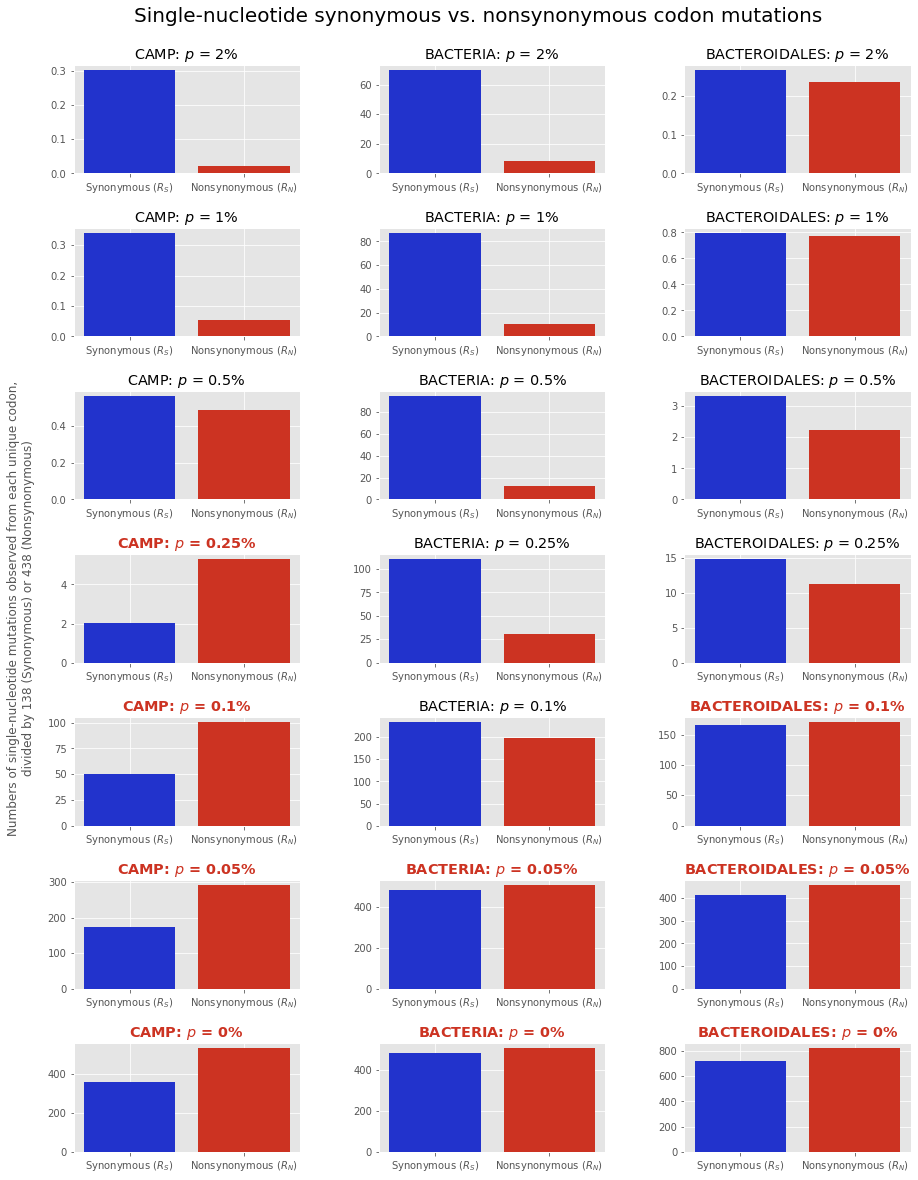

In [12]:
fig, axes = pyplot.subplots(len(percentages), 3, gridspec_kw={"hspace": 0.5, "wspace": 0.35})

if len(percentages) % 2 == 0:
    # Really, the precise middle is between two rows, right? anyway as of writing we use 7 percentages
    # so this never happens
    middle_row = len(percentages) / 2
else:
    middle_row = percentages.index(median(percentages))

for pi, p in enumerate(percentages):
    for si, seq in enumerate(SEQS):
        rs = p2seq2synvals[p][seq]["syn"] / 138
        rn = p2seq2synvals[p][seq]["nonsyn"] / 438
        axes[pi, si].bar(
            ["Synonymous ($R_S$)", "Nonsynonymous ($R_N$)"],
            [rs,rn],
            color=["#2233cc", "#cc3322"]
        )
        titlecolor="#000000"
        titleweight="normal"
        if rs <= rn:
            titlecolor="#cc3322"
            titleweight="semibold"
        axes[pi, si].set_title(f"{seq2name[seq]}: $p$ = {p}%", color=titlecolor, fontweight=titleweight)
        
        if pi == middle_row and si == 0:
            axes[pi, si].set_ylabel("Numbers of single-nucleotide mutations observed from each unique codon,\ndivided by 138 (Synonymous) or 438 (Nonsynonymous)", labelpad=25)
        
fig.suptitle("Single-nucleotide synonymous vs. nonsynonymous codon mutations", y=0.92, x=0.5, fontsize=20)
fig.set_size_inches(15, 20)
fig.savefig("figs/syn-nonsyn-snmut-barplots.png", bbox_inches="tight")

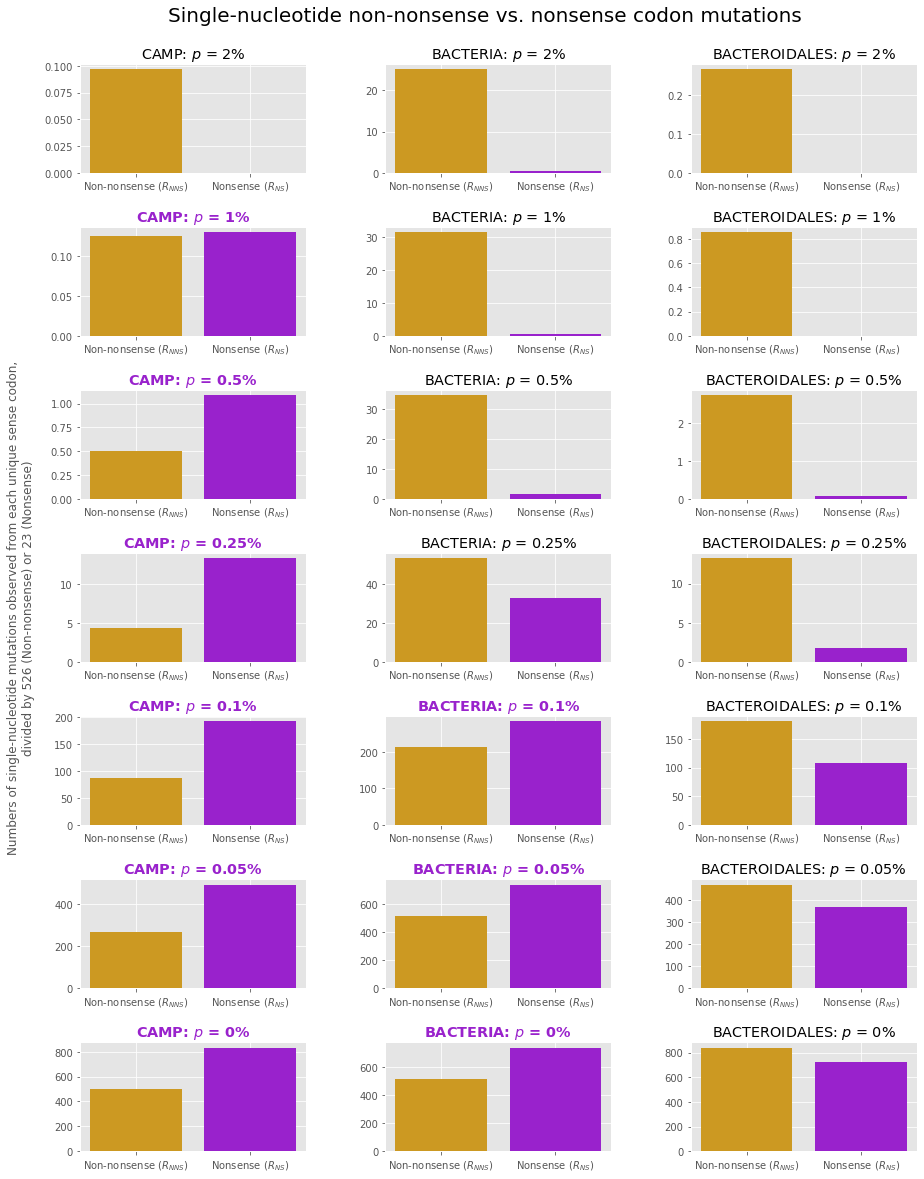

In [13]:
fig2, axes2 = pyplot.subplots(len(percentages), 3, gridspec_kw={"hspace": 0.5, "wspace": 0.35})

for pi, p in enumerate(percentages):
    for si, seq in enumerate(SEQS):
        rnns = p2seq2nonsensevals[p][seq]["nonnonsense"] / 526
        rns = p2seq2nonsensevals[p][seq]["nonsense"] / 23
        axes2[pi, si].bar(
            ["Non-nonsense ($R_{NNS}$)", "Nonsense ($R_{NS}$)"],
            [rnns, rns],
            color=["#cc9922", "#9922cc"]
        )
        
        titlecolor="#000000"
        titleweight="normal"
        if rnns <= rns:
            titlecolor="#9922cc"
            titleweight="semibold"
        axes2[pi, si].set_title(f"{seq2name[seq]}: $p$ = {p}%", color=titlecolor, fontweight=titleweight)
        
        if pi == middle_row and si == 0:
            axes2[pi, si].set_ylabel("Numbers of single-nucleotide mutations observed from each unique sense codon,\ndivided by 526 (Non-nonsense) or 23 (Nonsense)", labelpad=25)
        
fig2.suptitle("Single-nucleotide non-nonsense vs. nonsense codon mutations", y=0.92, x=0.5, fontsize=20)
fig2.set_size_inches(15, 20)
fig2.savefig("figs/nonnonsense-nonsense-snmut-barplots.png", bbox_inches="tight")

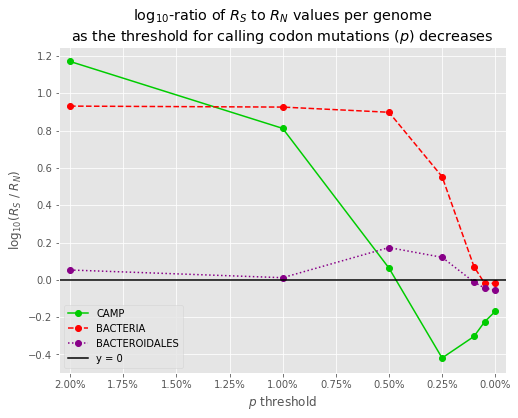

In [10]:
fig, ax = pyplot.subplots(1)

colors = ["#00cc00", "#ff0000", "#880088"]
linestyles = ["-", "--", ":"]
for si, seq in enumerate(SEQS):
    ratios = []
    for pi, p in enumerate(percentages):
        rs = (p2seq2synvals[p][seq]["syn"] / 138)
        rn = (p2seq2synvals[p][seq]["nonsyn"] / 438)
        ratios.append(log(rs / rn, 10))
    ax.plot(percentages, ratios, label=seq2name[seq], color=colors[si], linestyle=linestyles[si], marker="o")

# use xlim to invert x-axis, so that it goes from high -> low rather than low -> high:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/invert_axes.html
ax.set_xlim(2.05, -0.05)

# Show percentages on the x-axis:
# https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
ax.get_xaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100, decimals=2))

ax.axhline(y=0, color="black", label="y = 0")

ax.set_xlabel("$p$ threshold")
ax.set_ylabel("$\log_{10} ( R_S\  /\  R_N )$")
ax.set_title("$\log_{10}$-ratio of $R_S$ to $R_N$ values per genome\nas the threshold for calling codon mutations ($p$) decreases")
ax.legend()
fig.set_size_inches(8, 6)
fig.savefig("figs/syn-nonsyn-ratios.png", bbox_inches="tight")

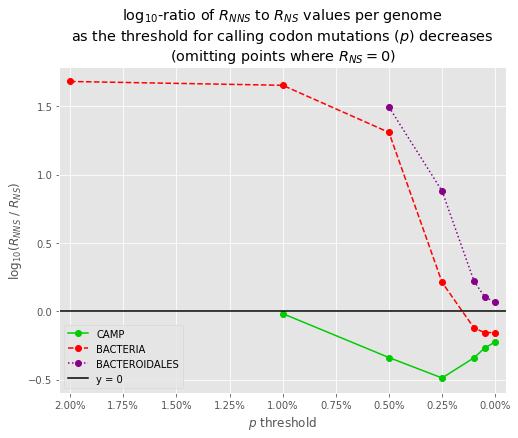

In [11]:
fig, ax = pyplot.subplots(1)

for si, seq in enumerate(SEQS):
    ratios = []
    for pi, p in enumerate(percentages):
        rnns = (p2seq2nonsensevals[p][seq]["nonnonsense"] / 526)
        rns = (p2seq2nonsensevals[p][seq]["nonsense"] / 23)
        if rns > 0 and rnns > 0:
            ratios.append(log(rnns / rns, 10))
        else:
            ratios.append(None)
    ax.plot(percentages, ratios, label=seq2name[seq], color=colors[si], linestyle=linestyles[si], marker="o")

ax.set_xlim(2.05, -0.05)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100, decimals=2))

ax.axhline(y=0, color="black", label="y = 0")

ax.set_xlabel("$p$ threshold")
ax.set_ylabel("$\log_{10} ( R_{NNS}\  /\  R_{NS} )$")
# If there were any points where R_{NNS} = 0 we should include that in the title, but as the barplots make clear
# no points fit this description
ax.set_title("$\log_{10}$-ratio of $R_{NNS}$ to $R_{NS}$ values per genome\nas the threshold for calling codon mutations ($p$) decreases\n(omitting points where $R_{NS} = 0$)")
ax.legend()
fig.set_size_inches(8, 6)
fig.savefig("figs/nonnonsense-nonsense-ratios.png", bbox_inches="tight")